In [ ]:
! pip install pytorch-lightning --upgrade

In [3]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
import pytorch_lightning as L
import numpy as np

In [94]:
def generate_data(x_range=(-4, 4), num_points=1000):
    x = np.linspace(x_range[0], x_range[1], num_points)
    y = np.polyval([1,0,0,0], x)
    y += np.random.normal(0,3, size=num_points)
    return torch.tensor(x, dtype=torch.float32).view(-1,1), torch.tensor(y, dtype=torch.float32).view(-1,1)

def negative_log_likelihood(pred_targets, pred_var, targets):
  clamped_var = torch.clamp(pred_var, min=0.00001)
  return torch.log(2*np.pi*clamped_var) / 2 + (pred_targets - targets)**2 / (2 * clamped_var)


def evidential_loss(gamma, alpha, beta, v, targets, lam=0.01):

  alpha = torch.clamp(alpha, min=1.00001)
  beta = torch.clamp(beta, min=0.00001)
  v = torch.clamp(v, min=0.00001)


  twoBlambda = 2*beta*(1+v)
  nll = 0.5*torch.log(np.pi/v) \
      - alpha*torch.log(twoBlambda) \
      + (alpha+0.5) * torch.log(v*(targets-gamma)**2 + twoBlambda) \
      + torch.lgamma(alpha) \
      - torch.lgamma(alpha+0.5)

  error = torch.abs((targets - gamma))
  reg = error * (2 * v + alpha)

  return nll + lam*reg


In [136]:
class sandbox(L.LightningModule):
  def __init__(self):
    super().__init__()

    self.ffn = nn.Sequential(
        nn.Linear(1,100),
        nn.ReLU(),
        nn.Linear(100,100),
        nn.ReLU(),
        nn.Linear(100,100),
        nn.ReLU(),
        nn.Linear(100,4)
    )

    self.lr = 0.0005

  def forward(self, input):

    output = self.ffn(input)

    return output

  def configure_optimizers(self):

    return optim.Adam(self.parameters(), lr=self.lr)

  def training_step(self, batch, batch_idx):

    input_i, label_i = batch
    label_i = torch.flatten(label_i)
    output_i = self.ffn(input_i)

    preds_i, alpha_i, beta_i, v_i = output_i[:,0], F.softplus(output_i[:,1])+1, F.softplus(output_i[:,2]), F.softplus(output_i[:,3])

    loss = torch.mean(evidential_loss(preds_i, alpha_i, beta_i, v_i, label_i))

    return loss



In [137]:
x_train, y_train = generate_data()
x_test, y_test = generate_data(x_range=(-6,6))

train_data = TensorDataset(x_train, y_train)
test_data = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
test_loader = DataLoader(test_data, batch_size=100, shuffle=True)

model = sandbox()
trainer = L.Trainer(max_epochs=500)

trainer.fit(model, train_dataloaders=train_loader)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type       | Params
------------------------------------
0 | ffn  | Sequential | 20.8 K
------------------------------------
20.8 K    Trainable params
0         Non-trainable params
20.8 K    Total params
0.083     Total estimated model params size (MB)
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=500` reached.


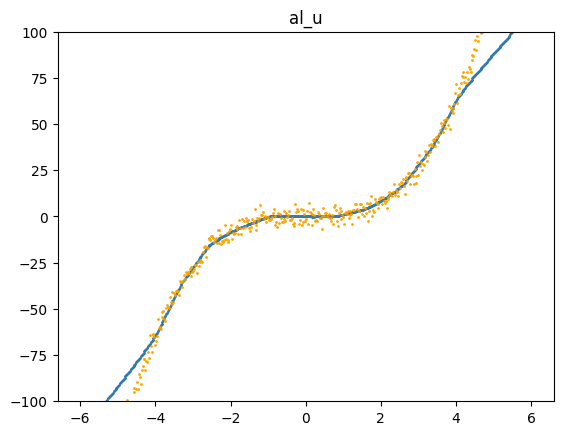

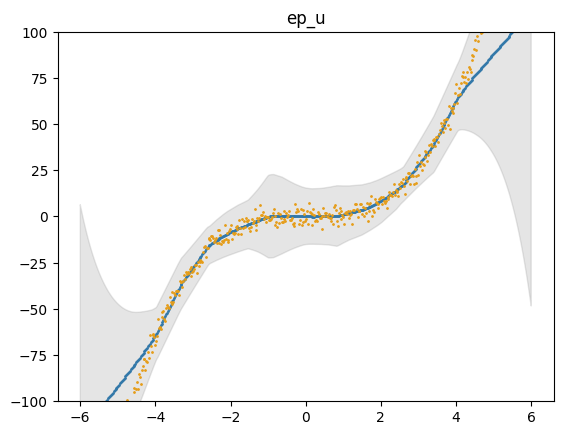

In [140]:
import seaborn as sns
import matplotlib.pyplot as plt


train_x, train_y = generate_data(x_range=(-6,6))
temp = model(train_x)

preds = temp[:,0].detach()
alpha = F.softplus(temp[:,1].detach()) + 1
beta = F.softplus(temp[:,2].detach())
v = F.softplus(temp[:,3].detach())

al_u = beta/(alpha-1)
ep_u = al_u/v


x = torch.flatten(train_x)

plt.title("al_u")
plt.scatter(x, preds, s=1)
plt.scatter(x, train_y,s=1, color="orange")
plt.fill_between(x, preds-al_u, preds+al_u, color="gray", alpha=0.2)
plt.ylim(-100,100)
plt.show()

plt.title("ep_u")
plt.scatter(x, preds, s=1)
plt.scatter(x, train_y,s=1, color="orange")
plt.fill_between(x, preds-ep_u, preds+ep_u, color="gray", alpha=0.2)
plt.ylim(-100,100)
plt.show()



In [139]:
print(al_u)

tensor([2.9769e-06, 3.1790e-06, 3.3948e-06, 3.6254e-06, 3.8717e-06, 4.1348e-06,
        4.4158e-06, 4.7158e-06, 5.0362e-06, 5.3784e-06, 5.7439e-06, 6.1342e-06,
        6.5511e-06, 6.9962e-06, 7.4717e-06, 7.9794e-06, 8.5217e-06, 9.1008e-06,
        9.7193e-06, 1.0380e-05, 1.1085e-05, 1.1839e-05, 1.2643e-05, 1.3503e-05,
        1.4420e-05, 1.5400e-05, 1.6447e-05, 1.7564e-05, 1.8755e-05, 2.0027e-05,
        2.1385e-05, 2.2835e-05, 2.4384e-05, 2.6038e-05, 2.7804e-05, 2.9690e-05,
        3.1703e-05, 3.3854e-05, 3.6150e-05, 3.8602e-05, 4.1220e-05, 4.4016e-05,
        4.7001e-05, 5.0189e-05, 5.3596e-05, 5.7236e-05, 6.1124e-05, 6.5269e-05,
        6.9680e-05, 7.4391e-05, 7.9419e-05, 8.4788e-05, 9.0520e-05, 9.6639e-05,
        1.0317e-04, 1.1015e-04, 1.1760e-04, 1.2569e-04, 1.3433e-04, 1.4357e-04,
        1.5344e-04, 1.6399e-04, 1.7523e-04, 1.8717e-04, 1.9992e-04, 2.1348e-04,
        2.2779e-04, 2.4304e-04, 2.5931e-04, 2.7667e-04, 2.9492e-04, 3.1463e-04,
        3.3569e-04, 3.5791e-04, 3.8158e-